In [1]:
import kagglehub
import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

import torch
from torch.utils.data import Dataset, DataLoader

2024-12-11 11:50:04.397268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = kagglehub.dataset_download("fmena14/volcanoesvenus")
print("Path to dataset files:", path)

files = os.listdir(path)
print(files)

Path to dataset files: /Users/elisaottoboni/.cache/kagglehub/datasets/fmena14/volcanoesvenus/versions/1
['Volcanoes_train', 'Volcanoes_test']


In [3]:
print(os.listdir(path))

X_train = pd.read_csv(os.path.join(path, 'volcanoes_train', 'train_images.csv'))
y_train = pd.read_csv(os.path.join(path, 'volcanoes_train', 'train_labels.csv'))
X_test = pd.read_csv(os.path.join(path, 'volcanoes_test', 'test_images.csv'))
y_test = pd.read_csv(os.path.join(path, 'volcanoes_test', 'test_labels.csv'))

['Volcanoes_train', 'Volcanoes_test']


In [4]:
print(X_train.head())
print(y_train.head())

    95  101   99  103  95.1   86   96   89   70  104  ...  111.214  107.329  \
0   91   92   91   89    92   93   96  101  107  104  ...      103       92   
1   87   70   72   74    84   78   93  104  106  106  ...       84       71   
2    0    0    0    0     0    0    0    0    0    0  ...       94       81   
3  114  118  124  119    95  118  105  116  123  112  ...      116      113   
4   79   95   90   82    73   74   77   75   82   87  ...       90       80   

   92.354  89.258  103.379  99.414  117.112  116.103  118.82  96.423  
0      93      95       98     105      104      100      90      81  
1      95     102       94      80       91       80      84      90  
2      89      84       80      90       92       80      88      96  
3     102      93      109     104      106      117     111     115  
4      79      78       65      71       62       97      89      73  

[5 rows x 12100 columns]
   Volcano?  Type  Radius  Number Volcanoes
0         1   3.0   17.46    

In [5]:
def XFix(X):
    X.loc[-1] = X.columns.values.astype(float).astype(int)  # adding column names as a new row
    X.index = X.index + 1  # shifting index
    X.sort_index(inplace=True)  # sorting the index

XFix(X_train)
XFix(X_test)

y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]

In [6]:
X_train = X_train.values.astype(np.float32)
y_train = y_train.values.astype(np.int64)
X_test = X_test.values.astype(np.float32)
y_test = y_test.values.astype(np.int64)

# Normalize pixel values to [0, 1]
X_train = ((X_train / 255.) - .5) * 2
X_test = ((X_test / 255.) - .5) * 2

y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [7]:
# import torchvision
# from torchvision import transforms
# in this case, we dont have to transform images in tensor because we have images in csv

class VolcanoDataset(Dataset):
    def __init__ (self, images, labels):
        self.images = torch.tensor(images, dtype = torch.float64)
        self.labels = torch.tensor(labels, dtype = torch.float64)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = VolcanoDataset(X_train, y_train)
test_dataset = VolcanoDataset(X_test, y_test)

In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import numpy as np

hidden_units = [64, 32]  # Neurons in hidden layers
input_size = X_train.shape[1]  # 12100 (110x110)
output_size = len(np.unique(y_train))  # Number of classes or output features

class FeedforwardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, dropout_probability = 0.5, activation_function = nn.ReLU()):
        super(FeedforwardNeuralNet, self).__init__()
        layers = []
        # Construct hidden layers
        for hidden_unit in hidden_units:
            layers.append(nn.Linear(input_size, hidden_unit))  # Fully connected layer
            layers.append(activation_function)  # Activation function
            layers.append(nn.Dropout(p=dropout_probability))  # Dropout for regularization
            input_size = hidden_unit  # Update input size for the next layer
        
        layers.append(nn.Linear(hidden_units[-1], output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


dropout_probability = 0.5
activation_function = nn.ReLU()
model = FeedforwardNeuralNet(input_size, hidden_units, output_size, dropout_probability, activation_function)
print(model)

FeedforwardNeuralNet(
  (model): Sequential(
    (0): Linear(in_features=12100, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
torch.manual_seed(1)

def train_model(model, train_loader, epochs = 25, device = None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for images, labels in train_loader:
            images = images.to(device).float()  # Ensure images are float32 and on the correct device
            labels = labels.to(device).long()  # Ensure labels are long and on the correct device

            # Convert one-hot encoded labels to class indices
            if labels.dim() == 2:  # Check if labels are one-hot encoded
                labels = torch.argmax(labels, dim=1)
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    accuracy = correct_preds / total_preds
    print(f'Accuracy: {accuracy:.4f}')

In [11]:
train_model(model, train_loader)

Epoch 1/25, Loss: 0.5129, Accuracy: 0.8387
Epoch 2/25, Loss: 0.4471, Accuracy: 0.8559
Epoch 3/25, Loss: 0.4045, Accuracy: 0.8561
Epoch 4/25, Loss: 0.3853, Accuracy: 0.8567
Epoch 5/25, Loss: 0.3856, Accuracy: 0.8574
Epoch 6/25, Loss: 0.3763, Accuracy: 0.8561
Epoch 7/25, Loss: 0.3751, Accuracy: 0.8589
Epoch 8/25, Loss: 0.3755, Accuracy: 0.8607
Epoch 9/25, Loss: 0.3479, Accuracy: 0.8719
Epoch 10/25, Loss: 0.3306, Accuracy: 0.8771
Epoch 11/25, Loss: 0.3355, Accuracy: 0.8720
Epoch 12/25, Loss: 0.3362, Accuracy: 0.8821
Epoch 13/25, Loss: 0.3040, Accuracy: 0.8921
Epoch 14/25, Loss: 0.3212, Accuracy: 0.8930
Epoch 15/25, Loss: 0.3150, Accuracy: 0.8990
Epoch 16/25, Loss: 0.3060, Accuracy: 0.8967
Epoch 17/25, Loss: 0.2932, Accuracy: 0.9054
Epoch 18/25, Loss: 0.2747, Accuracy: 0.9106
Epoch 19/25, Loss: 0.2865, Accuracy: 0.9026
Epoch 20/25, Loss: 0.2719, Accuracy: 0.9093
Epoch 21/25, Loss: 0.2635, Accuracy: 0.9167
Epoch 22/25, Loss: 0.2630, Accuracy: 0.9141
Epoch 23/25, Loss: 0.2499, Accuracy: 0.92

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss_list, train_acc_list, test_loss_list, test_acc_list, name, epochs=25):
    # Plotting
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), train_loss_list, label="Train Loss", color='blue', linewidth=3)
    plt.plot(range(1, epochs + 1), test_loss_list, label="Test Loss", color='orange', linestyle='--', linewidth=3)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title(f"Loss vs. Epochs")

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), train_acc_list, label="Train Accuracy", color='blue', linewidth=3)
    plt.plot(range(1, epochs + 1), test_acc_list, label="Test Accuracy", color='orange', linestyle='--', linewidth=3)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title(f"Accuracy vs. Epochs")

    plt.tight_layout()
    plt.savefig(f'images/{name}_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
import torch
import torch.nn as nn
torch.manual_seed(1)

def train_fnn(model, train_loader, test_loader, epochs=25, lr=0.001, optimizer_fn=None, device=None):
    """
    Train a feedforward neural network.

    Parameters:
    - model: The neural network model.
    - train_loader: DataLoader for the training set.
    - test_loader: DataLoader for the test set.
    - epochs: Number of training epochs.
    - lr: Learning rate.
    - optimizer_fn: Function or class for the optimizer (default: Adam).
    - device: Device to train on (default: cuda if available).

    Returns:
    - train_loss_list: List of training losses per epoch.
    - train_acc_list: List of training accuracies per epoch.
    - test_loss_list: List of test losses per epoch.
    - test_acc_list: List of test accuracies per epoch.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    
    # Loss function
    loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification

    # Define optimizer
    if optimizer_fn is None:
        optimizer_fn = lambda params: torch.optim.Adam(params, lr=lr)  # Default optimizer is Adam
    optimizer = optimizer_fn(model.parameters())

    for epoch in range(epochs):
        # ------------------------------ Train set ------------------------------
        model.train()
        train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0
        
        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device).long()
            
            # Convert one-hot encoded labels to class indices (if applicable)
            if labels.dim() == 2:
                labels = torch.argmax(labels, dim=1)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)
            
        # Compute epoch metrics
        train_loss /= len(train_loader)
        train_accuracy = correct_train_preds / total_train_preds
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)
        
        # ------------------------------ Test set ------------------------------
        model.eval()
        test_loss = 0.0
        correct_test_preds = 0
        total_test_preds = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device).float()
                labels = labels.to(device).long()

                if labels.dim() == 2:
                    labels = torch.argmax(labels, dim=1)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_test_preds += (predicted == labels).sum().item()
                total_test_preds += labels.size(0)
            
        test_loss /= len(test_loader)
        test_accuracy = correct_test_preds / total_test_preds
        test_loss_list.append(test_loss)
        test_acc_list.append(test_accuracy)
        
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

Testing optimizer: Adam
Optimizer: Adam, Learning rate 0.0000001, Epochs 20, final test accuracy: 0.9283102
Optimizer: Adam, Learning rate 0.0000001, Epochs 30, final test accuracy: 0.9286759
Optimizer: Adam, Learning rate 0.0000001, Epochs 40, final test accuracy: 0.9297732
Optimizer: Adam, Learning rate 0.0001667, Epochs 20, final test accuracy: 0.9374543
Optimizer: Adam, Learning rate 0.0001667, Epochs 30, final test accuracy: 0.9400146
Optimizer: Adam, Learning rate 0.0001667, Epochs 40, final test accuracy: 0.9367228
Optimizer: Adam, Learning rate 0.0003334, Epochs 20, final test accuracy: 0.9279444
Optimizer: Adam, Learning rate 0.0003334, Epochs 30, final test accuracy: 0.9407462
Optimizer: Adam, Learning rate 0.0003334, Epochs 40, final test accuracy: 0.9392831
Optimizer: Adam, Learning rate 0.0005000, Epochs 20, final test accuracy: 0.9334309
Optimizer: Adam, Learning rate 0.0005000, Epochs 30, final test accuracy: 0.9345282
Optimizer: Adam, Learning rate 0.0005000, Epochs 40,

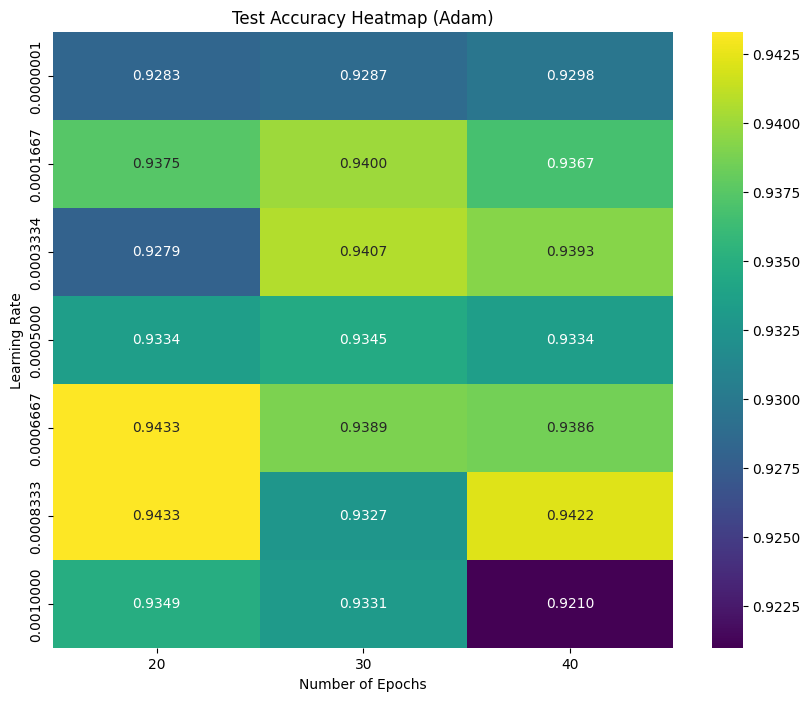

Best results for Adam:
  Learning rate: 0.0006667
  Number of epochs: 20
  Test accuracy: 0.9433065

Testing optimizer: SGD
Optimizer: SGD, Learning rate 0.0000001, Epochs 20, final test accuracy: 0.9209949
Optimizer: SGD, Learning rate 0.0000001, Epochs 30, final test accuracy: 0.9209949
Optimizer: SGD, Learning rate 0.0000001, Epochs 40, final test accuracy: 0.9209949
Optimizer: SGD, Learning rate 0.0001667, Epochs 20, final test accuracy: 0.9396489
Optimizer: SGD, Learning rate 0.0001667, Epochs 30, final test accuracy: 0.9378200
Optimizer: SGD, Learning rate 0.0001667, Epochs 40, final test accuracy: 0.9385516
Optimizer: SGD, Learning rate 0.0003334, Epochs 20, final test accuracy: 0.9392831
Optimizer: SGD, Learning rate 0.0003334, Epochs 30, final test accuracy: 0.9378200
Optimizer: SGD, Learning rate 0.0003334, Epochs 40, final test accuracy: 0.9370885
Optimizer: SGD, Learning rate 0.0005000, Epochs 20, final test accuracy: 0.9367228
Optimizer: SGD, Learning rate 0.0005000, Epoch

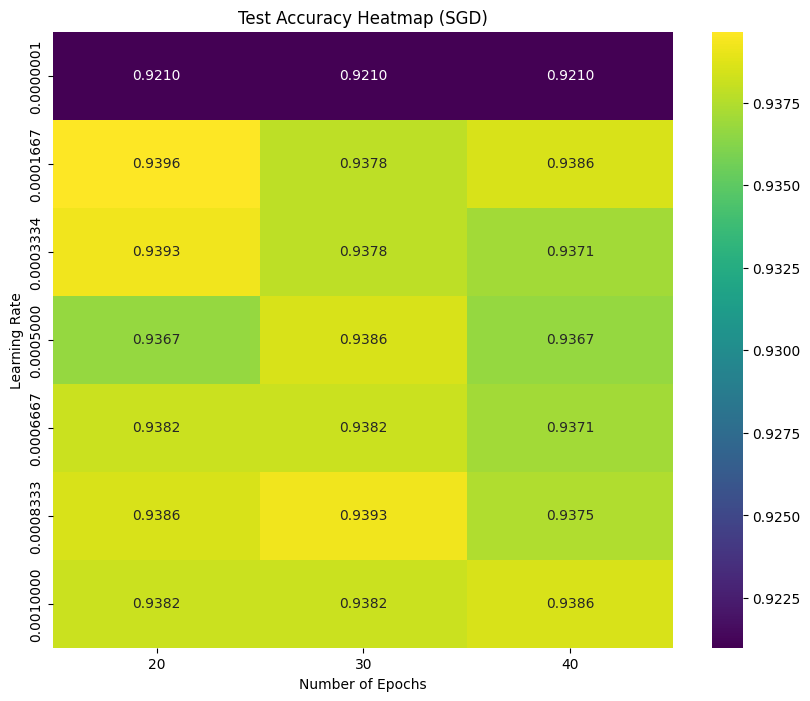

Best results for SGD:
  Learning rate: 0.0001667
  Number of epochs: 20
  Test accuracy: 0.9396489

Testing optimizer: RMSprop
Optimizer: RMSprop, Learning rate 0.0000001, Epochs 20, final test accuracy: 0.9385516
Optimizer: RMSprop, Learning rate 0.0000001, Epochs 30, final test accuracy: 0.9385516
Optimizer: RMSprop, Learning rate 0.0000001, Epochs 40, final test accuracy: 0.9385516
Optimizer: RMSprop, Learning rate 0.0001667, Epochs 20, final test accuracy: 0.9411119
Optimizer: RMSprop, Learning rate 0.0001667, Epochs 30, final test accuracy: 0.9378200
Optimizer: RMSprop, Learning rate 0.0001667, Epochs 40, final test accuracy: 0.9403804
Optimizer: RMSprop, Learning rate 0.0003334, Epochs 20, final test accuracy: 0.9433065
Optimizer: RMSprop, Learning rate 0.0003334, Epochs 30, final test accuracy: 0.9407462
Optimizer: RMSprop, Learning rate 0.0003334, Epochs 40, final test accuracy: 0.9429407
Optimizer: RMSprop, Learning rate 0.0005000, Epochs 20, final test accuracy: 0.9403804
Opt

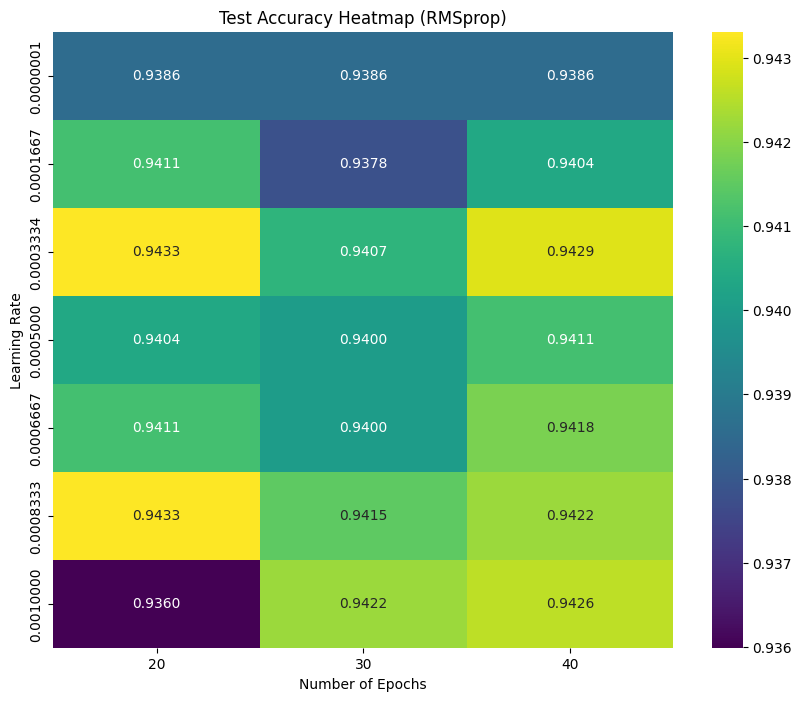

Best results for RMSprop:
  Learning rate: 0.0003334
  Number of epochs: 20
  Test accuracy: 0.9433065

Optimizer: Adam, Learning Rate: 0.0006667, Epochs: 20, Accuracy: 0.9433065
Optimizer: SGD, Learning Rate: 0.0001667, Epochs: 20, Accuracy: 0.9396489
Optimizer: RMSprop, Learning Rate: 0.0003334, Epochs: 20, Accuracy: 0.9433065


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

torch = __import__('torch') 
lrs = np.linspace(0.0000001, 0.001, 7)
epochs_list = [20, 30, 40]

optimizers = {
    "Adam": lambda params, lr: torch.optim.Adam(params, lr=lr),
    "SGD": lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9),
    "RMSprop": lambda params, lr: torch.optim.RMSprop(params, lr=lr)
}

results = {}
best_results = []

for optimizer_name, optimizer_fn in optimizers.items():
    results_matrix = np.zeros((len(lrs), len(epochs_list)))
    print(f"Testing optimizer: {optimizer_name}")
    
    for i, lr in enumerate(lrs):
        for j, epochs in enumerate(epochs_list):
            train_loss, train_acc, test_loss, test_acc = train_fnn(
                model, train_loader, test_loader, epochs=epochs, lr=lr, optimizer_fn=lambda params: optimizer_fn(params, lr)
            )
            results_matrix[i, j] = test_acc[-1]
            print(f"Optimizer: {optimizer_name}, Learning rate {lr:.7f}, Epochs {epochs}, final test accuracy: {test_acc[-1]:.7f}")
            
            if results_matrix[i, j] > results.get((optimizer_name, "best_accuracy"), -np.inf):
                results[(optimizer_name, "train_loss")] = train_loss
                results[(optimizer_name, "train_acc")] = train_acc
                results[(optimizer_name, "test_loss")] = test_loss
                results[(optimizer_name, "test_acc")] = test_acc
                results[(optimizer_name, "best_accuracy")] = results_matrix[i, j]
                results[(optimizer_name, "best_lr")] = lr
                results[(optimizer_name, "best_epochs")] = epochs

    results[optimizer_name] = results_matrix
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        results_matrix, annot=True, fmt=".4f",
        xticklabels=epochs_list, yticklabels=[f"{lr:.7f}" for lr in lrs], cmap="viridis"
    )
    plt.title(f"Test Accuracy Heatmap ({optimizer_name})")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Learning Rate")
    plt.savefig(f'images/Heatmap_{optimizer_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    best_idx = np.unravel_index(np.argmax(results_matrix), results_matrix.shape)
    best_lr = lrs[best_idx[0]]
    best_epochs = epochs_list[best_idx[1]]
    best_accuracy = results_matrix[best_idx]
    
    best_results.append({
        "optimizer": optimizer_name,
        "learning_rate": best_lr,
        "epochs": best_epochs,
        "accuracy": best_accuracy
    })

    print(f"Best results for {optimizer_name}:")
    print(f"  Learning rate: {best_lr:.7f}")
    print(f"  Number of epochs: {best_epochs}")
    print(f"  Test accuracy: {best_accuracy:.7f}")
    print()
    
for result in best_results:
    print(f"Optimizer: {result['optimizer']}, Learning Rate: {result['learning_rate']:.7f}, Epochs: {result['epochs']}, Accuracy: {result['accuracy']:.7f}")

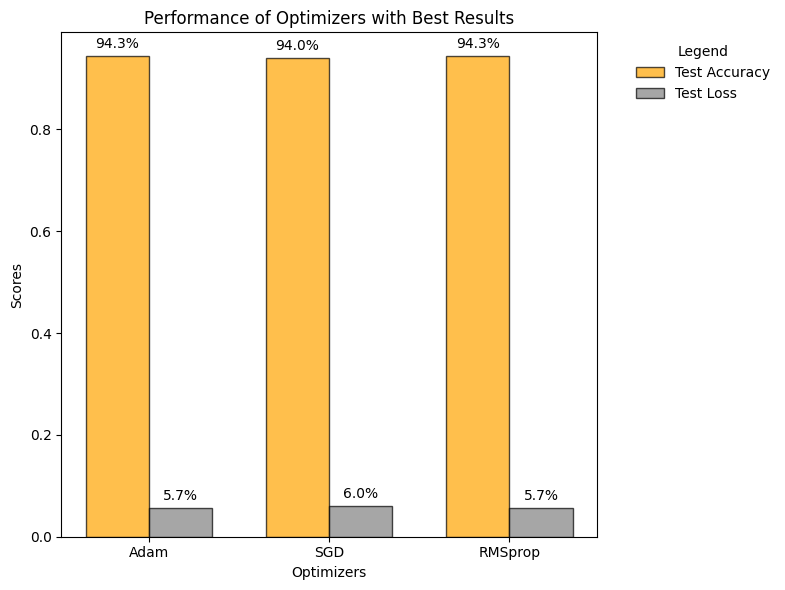

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract relevant data for plotting
x = [result["optimizer"] for result in best_results]
y_accuracy = [result["accuracy"] for result in best_results]  # Test Accuracy
y_loss = [1 - result["accuracy"] for result in best_results]  # Test Loss

bar_width = 0.35
x_positions = np.arange(len(x))

fig, ax1 = plt.subplots(figsize=(8, 6))

# Accuracy values
bars_accuracy = ax1.bar(x_positions - bar_width / 2, y_accuracy, width=bar_width, label='Test Accuracy', color='orange', edgecolor='black', alpha=0.7)
for bar, acc in zip(bars_accuracy, y_accuracy):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{acc * 100:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Loss values
bars_loss = ax1.bar(x_positions + bar_width / 2, y_loss, width=bar_width, label='Test Loss', color='grey', edgecolor='black', alpha=0.7)
for bar, loss in zip(bars_loss, y_loss):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{loss * 100:.1f}%', 
             ha='center', va='bottom', fontsize=10)

ax1.set_xticks(x_positions)
ax1.set_xticklabels(x)
ax1.set_xlabel('Optimizers')
ax1.set_ylabel('Scores')
ax1.set_title('Performance of Optimizers with Best Results')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend", frameon=False)

plt.tight_layout()
plt.savefig(f'images/optimizers_performance.png', dpi=300, bbox_inches='tight')
plt.show()

Best Overall Result:
  Optimizer: Adam
  Learning Rate: 0.0006667
  Epochs: 20
  Test Accuracy: 0.9433065


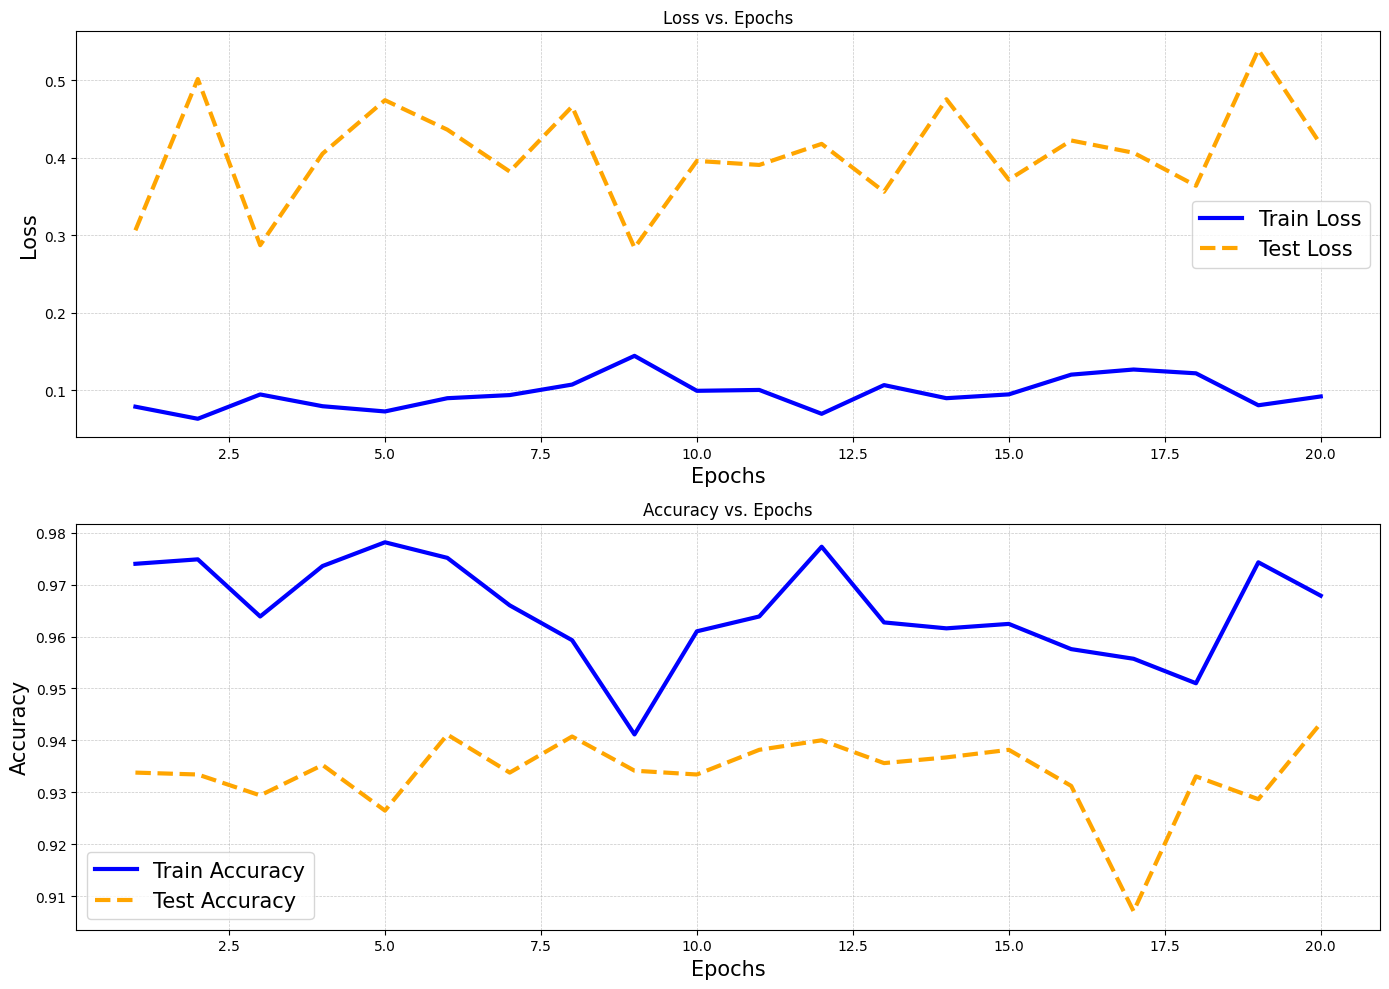

In [16]:
best_overall = max(best_results, key=lambda x: x["accuracy"])

optimizer_name = best_overall["optimizer"]
best_lr = best_overall["learning_rate"]
best_epochs = best_overall["epochs"]
train_loss = results[(optimizer_name, "train_loss")]
train_acc = results[(optimizer_name, "train_acc")]
test_loss = results[(optimizer_name, "test_loss")]
test_acc = results[(optimizer_name, "test_acc")]

print(f"Best Overall Result:")
print(f"  Optimizer: {optimizer_name}")
print(f"  Learning Rate: {best_lr:.7f}")
print(f"  Epochs: {best_epochs}")
print(f"  Test Accuracy: {best_overall['accuracy']:.7f}")

plot_metrics(
    train_loss_list=train_loss,
    train_acc_list=train_acc,
    test_loss_list=test_loss,
    test_acc_list=test_acc,
    epochs=best_epochs,
    name=f"Overall_Best_{optimizer_name}_lr{best_lr:.7f}_epochs{best_epochs}"
)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder(sparse_output=False) 
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
X_test_aligned = X_train_scaled.shape[1]
y_test_aligned = y_train_encoded.shape[1]
history = model.fit(X_train_scaled, y_train_encoded, validation_split=0.2, epochs=25, batch_size=32, verbose=1)

min_samples = min(X_test_scaled.shape[0], y_test_encoded.shape[0])
X_test_aligned = X_test_scaled[:min_samples]
y_test_aligned = y_test_encoded[:min_samples]

print("X_test_aligned shape:", X_test_aligned.shape)
print("y_test_aligned shape:", y_test_aligned.shape)

# Evaluation on the test set
test_loss, test_accuracy = model.evaluate(X_test_aligned, y_test_aligned, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.5f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │       774,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 776,610 (2.96 MB)

 Trainable params: 776,610 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5087 - loss: 2.0397 - val_accuracy: 0.5007 - val_loss: 0.9951
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5968 - loss: 1.3423 - val_accuracy: 0.4879 - val_loss: 1.1142
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6265 - loss: 0.9339 - val_accuracy: 0.4871 - val_loss: 1.6074
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6448 - loss: 0.9320 - val_accuracy: 0.4821 - val_loss: 1.4402
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6747 - loss: 0.8227 - val_accuracy: 0.5043 - val_loss: 1.0161
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7308 - loss: 0.5945 - val_accuracy: 0.4964 - val_loss: 1.1173
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7431 - loss: 0.6773 - val_accuracy: 0.5136 - val_loss: 1.0007
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7356 - loss: 0.6033 - val_ac

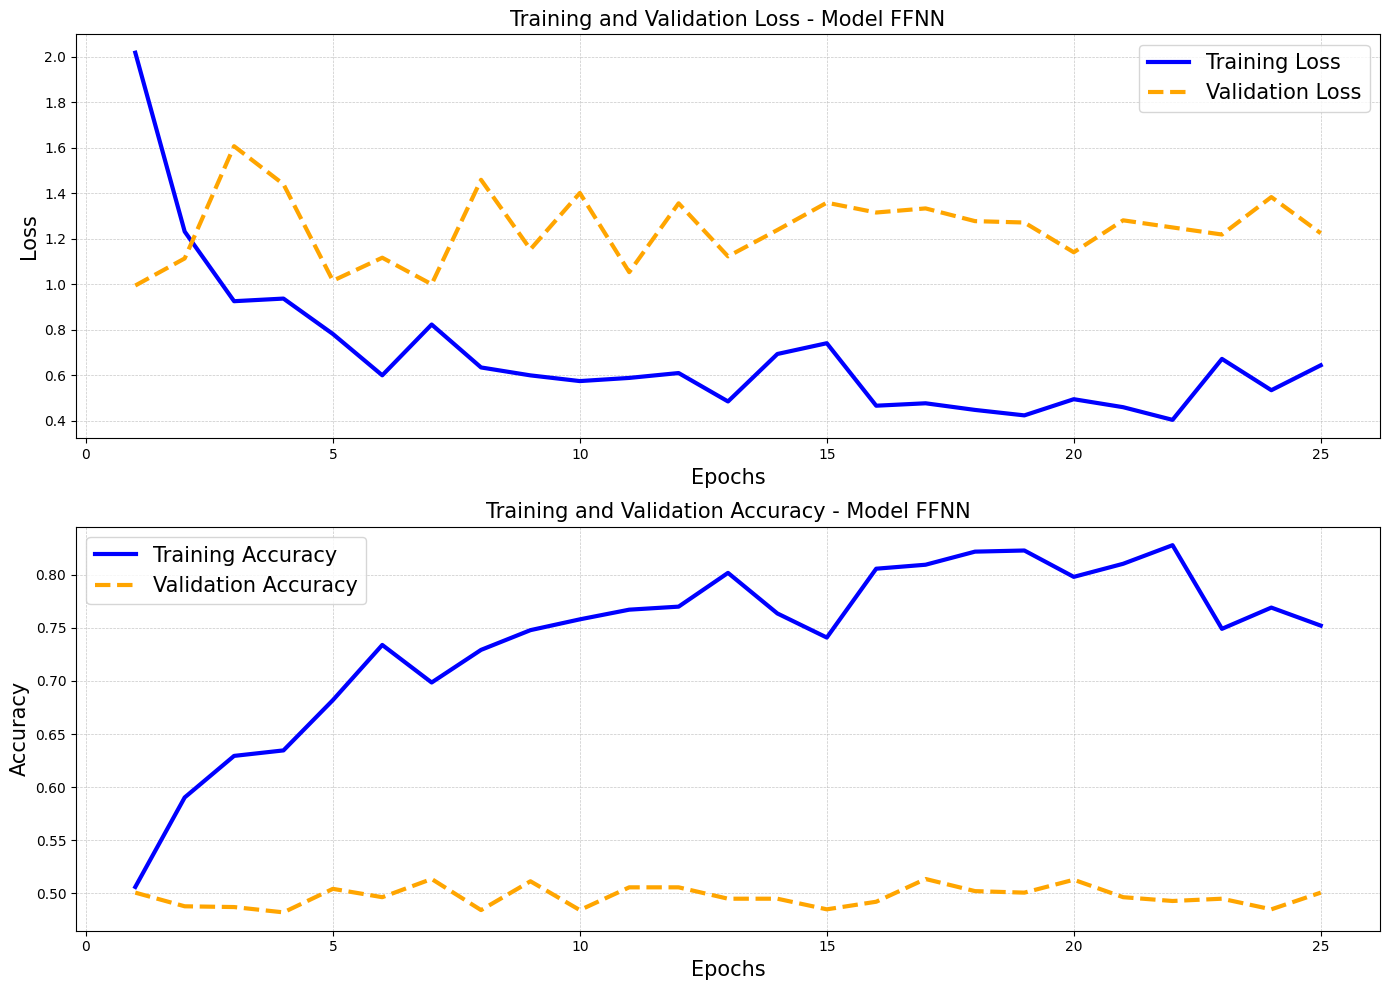

In [ ]:
from methods import *
training_results_graph(history, 'FFNN')